In [3]:
import pandas as pd
import plotly.express as px
from collections import Counter
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils.genres import *
from src.utils.genres import name_plot, count_genre_over_years, top_years_for_genre, bottom_years_for_genre, count_genres_by_year, calc_genre_differences, calc_genre_growth, calc_proportion_growth
import warnings
import csv
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ne_chunk
from nltk.sentiment import SentimentIntensityAnalyzer
from src.utils import google_trends as gt
#from data.Cleaning import final_df
warnings.simplefilter("ignore")
from ast import literal_eval
import plotly.graph_objects as go 

#### Extracting sides

In [4]:
df = pd.read_csv('data/movies_with_summaries.csv')
df.head()

,Movie_ID,IMDb_Index,Title,Original_Title,Release_Date,Year,Genres,Genres_IMDb,Rating,Votes,Revenue,Length,Languages,Countries,summary
0,975900,tt0228333,Ghosts of Mars,Ghosts of Mars,2001-08-24,2001,"['Thriller', 'Science Fiction', 'Horror', 'Adv...","['Action,Horror,Sci-Fi']",4.9,58872,14010832.0,98.0,['English Language'],['United States of America'],"Set in the second half of the 22nd century, th..."
1,261236,tt0083949,A Woman in Flames,Die flambierte Frau,1983,1983,['Drama'],['Drama'],5.9,648,NaN,106.0,['German Language'],['Germany'],"Eva, an upper class housewife, becomes frustra..."
2,171005,tt0097499,Henry V,Henry V,1989-11-08,1989,"['Costume drama', 'War film', 'Epic', 'Period ...","['Biography,Drama,History']",7.5,32088,10161099.0,137.0,['English Language'],['United Kingdom'],{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
3,77856,tt0058331,Mary Poppins,Mary Poppins,1964-08-27,1964,"['ChildrensFamily', 'Musical', 'Fantasy', 'Com...","['Comedy,Family,Fantasy']",7.8,189202,102272727.0,139.0,['English Language'],['United States of America'],The film opens with Mary Poppins perched in a...
4,32456683,tt0061637,Die Fahne von Kriwoj Rog,Die Fahne von Kriwoj Rog,1967,1967,[],['Drama'],7.7,24,NaN,108.0,['German Language'],['German Democratic Republic'],"Otto Brosowski, a communist miner, writes to t..."


In [5]:
# Download necessary NLTK packages for text processing and sentiment analysis
nltk.download('punkt')  # Tokenizer for splitting text into words
nltk.download('averaged_perceptron_tagger')  # POS tagger for grammatical structure
nltk.download('maxent_ne_chunker')  # NER chunker for extracting named entities
nltk.download('words')  # Word corpus for NER
nltk.download('stopwords')  # Common words to exclude from analysis
nltk.download('wordnet')  # Lexical database for English
nltk.download('vader_lexicon')  # Lexicon for sentiment analysis

# Define the set of English stopwords to remove common words that don't add meaning
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fatum\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\fatum\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\fatum\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\fatum\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fatum\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fatum\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-

In [6]:
df = pd.read_csv('data/movies_with_summaries.csv')
wars_df = pd.read_csv('data/wars_filtered_clean.csv')
df.head()

,Movie_ID,IMDb_Index,Title,Original_Title,Release_Date,Year,Genres,Genres_IMDb,Rating,Votes,Revenue,Length,Languages,Countries,summary
0,975900,tt0228333,Ghosts of Mars,Ghosts of Mars,2001-08-24,2001,"['Thriller', 'Science Fiction', 'Horror', 'Adv...","['Action,Horror,Sci-Fi']",4.9,58872,14010832.0,98.0,['English Language'],['United States of America'],"Set in the second half of the 22nd century, th..."
1,261236,tt0083949,A Woman in Flames,Die flambierte Frau,1983,1983,['Drama'],['Drama'],5.9,648,NaN,106.0,['German Language'],['Germany'],"Eva, an upper class housewife, becomes frustra..."
2,171005,tt0097499,Henry V,Henry V,1989-11-08,1989,"['Costume drama', 'War film', 'Epic', 'Period ...","['Biography,Drama,History']",7.5,32088,10161099.0,137.0,['English Language'],['United Kingdom'],{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
3,77856,tt0058331,Mary Poppins,Mary Poppins,1964-08-27,1964,"['ChildrensFamily', 'Musical', 'Fantasy', 'Com...","['Comedy,Family,Fantasy']",7.8,189202,102272727.0,139.0,['English Language'],['United States of America'],The film opens with Mary Poppins perched in a...
4,32456683,tt0061637,Die Fahne von Kriwoj Rog,Die Fahne von Kriwoj Rog,1967,1967,[],['Drama'],7.7,24,NaN,108.0,['German Language'],['German Democratic Republic'],"Otto Brosowski, a communist miner, writes to t..."


In [7]:
#WWII
wwii_bell = wars_df[wars_df['WarName']=='World War II'][['StateName', 'Side', 'Outcome']]
wwii_bell_side1 = wwii_bell[wwii_bell['Side'] == 1]['StateName'].values.tolist()
wwii_bell_side2 = wwii_bell[wwii_bell['Side'] == 2]['StateName'].values.tolist()
print(wwii_bell_side1)

#Cold War 
cold_bell = wars_df[wars_df['WarName']=='Cold War'][['StateName', 'Side', 'Outcome']]
cold_bell_side1 = cold_bell[cold_bell['Side'] == 1]['StateName'].values.tolist()
cold_bell_side2 = cold_bell[cold_bell['Side'] == 2]['StateName'].values.tolist()
soviet_equivalents = [
    'Soviet Union', 'USSR', 'Union of Soviet Socialist Republics', 
    'Russia', 'Russian Federation', 'Belarus', 'Ukraine', 'Kazakhstan',
    'Estonia', 'Latvia', 'Lithuania', 'Uzbekistan', 
    'Turkmenistan', 'Kyrgyzstan', 'Tajikistan',"Germany", "Albania",
    "East Germany","GDR","Bulgaria","Hungary","Poland","Romania",
    "Czechoslovakia","Yugoslavia"
]
cold_bell_side2.extend([country for country in soviet_equivalents if country not in cold_bell_side2])
print("Side 1 countries:", cold_bell_side1)
print("Side 2 countries:", cold_bell_side2)


#Korean
korean_bell = wars_df[wars_df['WarName']=='Korean'][['StateName', 'Side', 'Outcome']]
korean_bell_side1 = korean_bell[korean_bell['Side'] == 1]['StateName'].values.tolist()
korean_bell_side2 = korean_bell[korean_bell['Side'] == 2]['StateName'].values.tolist()
print(korean_bell_side1)

#Vietnam War
viet_bell = wars_df[wars_df['WarName']=='Vietnam War, Phase 2'][['StateName', 'Side', 'Outcome']]
viet_bell_side1 = viet_bell[viet_bell['Side'] == 1]['StateName'].values.tolist()
viet_bell_side2 = viet_bell[viet_bell['Side'] == 2]['StateName'].values.tolist()
print(viet_bell_side1)


['Belgium', 'Yugoslavia', 'Norway', 'Canada', 'United States of America', 'United Kingdom', 'Netherlands', 'Romania', 'Bulgaria', 'Greece', 'Brazil', 'Italy', 'Australia', 'New Zealand', 'USSR', 'Poland', 'France', 'Mongolia', 'China', 'South Africa', 'Ethiopia']
Side 1 countries: []
Side 2 countries: ['Soviet Union', 'USSR', 'Union of Soviet Socialist Republics', 'Russia', 'Russian Federation', 'Belarus', 'Ukraine', 'Kazakhstan', 'Estonia', 'Latvia', 'Lithuania', 'Uzbekistan', 'Turkmenistan', 'Kyrgyzstan', 'Tajikistan', 'Germany', 'Albania', 'East Germany', 'GDR', 'Bulgaria', 'Hungary', 'Poland', 'Romania', 'Czechoslovakia', 'Yugoslavia']
['Belgium', 'Canada', 'Colombia', 'United Kingdom', 'Netherlands', 'Greece', 'France', 'Turkey', 'Philippines', 'Thailand', 'Ethiopia', 'Australia', 'South Korea', 'United States of America']
['Vietnam']


In [8]:
# Filter rows where 'Genres' contains "WarMovie"
df_war_movies = df[df['Genres'].str.contains("War film", case=False, na=False)].reset_index(drop=True)

# Defining the function that detects specific keywords related to conflicts 
def label_event_regex(summary):
    if re.search(r"(World\sWar\sII|WWII|Hitler|Nazis|Hiroshima|Holocaust)", summary, re.IGNORECASE):
        return "World War II"
    elif re.search(r"(Vietnam\sWar|Viet\sCong|Saigon)", summary, re.IGNORECASE):
        return "Vietnam War"
    elif re.search(r"(Cold\sWar|Soviet\sUnion|USSR|communism|nuclear|Iron\sCurtain|Berlin\sWall|Cuban\sMissile\sCrisis|Space\sRace|Reagan|Stalin|KGB|Eastern\sBloc|Gorbachev|Perestroika|Glasnost)", summary, re.IGNORECASE):
        return "Cold War"
    elif re.search(r"(Kim|Korea|Korean|NKPA|Demilitarized\sZone|Pyongyang|Seoul|Joint\sChiefs\sof\sStaff)", summary, re.IGNORECASE):
        return "Korean"
    else:
        return "Other"

# Apply the function to the "summary" column 
df_war_movies['event'] = df_war_movies['summary'].apply(label_event_regex)

In [9]:
# Display movies labeled as "Cold War" for verification
df_war_movies[df_war_movies['event'] == "Cold War"].head()

,Movie_ID,IMDb_Index,Title,Original_Title,Release_Date,Year,Genres,Genres_IMDb,Rating,Votes,Revenue,Length,Languages,Countries,summary,event
6,21209475,tt0024915,British Agent,British Agent,1934-09-15,1934,"['Romantic drama', 'War film', 'Drama', 'Spy']","['Drama,History,Romance']",6.1,796,NaN,80.0,['English Language'],['United States of America'],In the days leading up to the Russian Revoluti...,Cold War
41,28209320,tt1382250,The Heart of No Place,The Heart of No Place,2009-03-21,2009,"['Musical', 'Drama', 'War film']","['Drama,Music,War']",8.2,26,NaN,85.0,[],[],Rock widow Y. tries to come to terms with the ...,Cold War
43,19245641,tt1300563,The Age of Stupid,The Age of Stupid,2009-02-06,2009,"['Social problem film', 'History', 'Experiment...","['Documentary,History,News']",7.0,4739,NaN,89.0,"['French Language', 'English Language']",['United Kingdom'],The film begins in the year 2055 in a world ra...,Cold War
93,189776,tt0114787,Underground,Underground,1995-04-01,1995,"['World cinema', 'Drama', 'Comedy', 'War film'...","['Comedy,Drama,Fantasy']",8.0,61979,171082.0,170.0,"['French Language', 'SerboCroatian', 'German L...","['Serbia and Montenegro', 'Bulgaria', 'France'...",{{Plot|datePart One: War19411944Part Two: Cold...,Cold War
151,1040736,tt0108211,Stalingrad,Stalingrad,1993,1993,"['Drama', 'World cinema', 'War film']","['Drama,War']",7.5,38359,152972.0,132.0,"['German Language', 'Russian Language']","['Sweden', 'Germany']","In August 1942, a group of German storm troope...",Cold War


In [10]:
# World War II
wwii_movies = df_war_movies[
    (df_war_movies['event'] == "World War II") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in (wwii_bell_side1 + wwii_bell_side2))))
]

wwii_movies_side1 = df_war_movies[
    (df_war_movies['event'] == "World War II") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in wwii_bell_side1)))
]

wwii_movies_side2 = df_war_movies[
    (df_war_movies['event'] == "World War II") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in wwii_bell_side2)))
]

sample_wwii_movies_side1 = wwii_movies_side1.sample(n=55, random_state=42)

print("-" * 40)
print(f"Shape of wwii_movies: {wwii_movies.shape}")
print(f"Shape of wwii_movies_side1: {wwii_movies_side1.shape}")
print(f"Shape of wwii_movies_side2: {wwii_movies_side2.shape}")
print(f"Shape of sample for verification: {sample_wwii_movies_side1.shape}")
print("-" * 40)

# # Identifier les films ayant des pays des deux sides
# movies_in_both_sides = wwii_movies_side1.index.intersection(wwii_movies_side2.index)

# # Retirer les films présents dans les deux sides des DataFrames exclusifs
# exclusive_wwii_movies_side1 = wwii_movies_side1.drop(movies_in_both_sides)
# exclusive_wwii_movies_side2 = wwii_movies_side2.drop(movies_in_both_sides)

# # Vérifier les tailles des DataFrames finaux
# print(f"Shape of wwii_movies: {wwii_movies.shape}")
# print(f"Shape of exclusive_wwii_movies_side1: {exclusive_wwii_movies_side1.shape}")
# print(f"Shape of exclusive_wwii_movies_side2: {exclusive_wwii_movies_side2.shape}")

# Cold War
cold_war_movies = df_war_movies[
    (df_war_movies['event'] == "Cold War") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in (cold_bell_side1 + cold_bell_side2))))
]

cold_war_movies_side1 = df_war_movies[
    (df_war_movies['event'] == "Cold War") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in cold_bell_side1)))
]

cold_war_movies_side2 = df_war_movies[
    (df_war_movies['event'] == "Cold War") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in cold_bell_side2)))
]


print("-" * 40)
print(f"Shape of cold_war_movies: {cold_war_movies.shape}")
print(f"Shape of cold_war_movies_side1: {cold_war_movies_side1.shape}")
print(f"Shape of cold_war_movies_side2: {cold_war_movies_side2.shape}")
print("-" * 40)

# Vietnam War
vietnam_war_movies = df_war_movies[
    (df_war_movies['event'] == "Vietnam War") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in (viet_bell_side1 + viet_bell_side2))))
]

vietnam_war_movies_side1 = df_war_movies[
    (df_war_movies['event'] == "Vietnam War") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in viet_bell_side1)))
]

vietnam_war_movies_side2 = df_war_movies[
    (df_war_movies['event'] == "Vietnam War") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in viet_bell_side2)))
]

print("-" * 40)
print(f"Shape of vietnam_war_movies: {vietnam_war_movies.shape}")
print(f"Shape of vietnam_war_movies_side1: {vietnam_war_movies_side1.shape}")
print(f"Shape of vietnam_war_movies_side2: {vietnam_war_movies_side2.shape}")
print("-" * 40)

# Korean War
korean_war_movies = df_war_movies[
    (df_war_movies['event'] == "Korean") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in (korean_bell_side1 + korean_bell_side2))))
]

korean_war_movies_side1 = df_war_movies[
    (df_war_movies['event'] == "Korean") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in korean_bell_side1)))
]

korean_war_movies_side2 = df_war_movies[
    (df_war_movies['event'] == "Korean") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in korean_bell_side2)))
]

print("-" * 40)
print(f"Shape of korean_war_movies: {korean_war_movies.shape}")
print(f"Shape of korean_war_movies_side1: {korean_war_movies_side1.shape}")
print(f"Shape of korean_war_movies_side2: {korean_war_movies_side2.shape}")
print("-" * 40)

----------------------------------------
Shape of wwii_movies: (242, 16)
Shape of wwii_movies_side1: (231, 16)
Shape of wwii_movies_side2: (63, 16)
Shape of sample for verification: (55, 16)
----------------------------------------
----------------------------------------
Shape of cold_war_movies: (14, 16)
Shape of cold_war_movies_side1: (0, 16)
Shape of cold_war_movies_side2: (14, 16)
----------------------------------------
----------------------------------------
Shape of vietnam_war_movies: (39, 16)
Shape of vietnam_war_movies_side1: (0, 16)
Shape of vietnam_war_movies_side2: (39, 16)
----------------------------------------
----------------------------------------
Shape of korean_war_movies: (49, 16)
Shape of korean_war_movies_side1: (48, 16)
Shape of korean_war_movies_side2: (4, 16)
----------------------------------------


TODO: Partie Flavia ici

#### Sentiment Analysis

In [11]:
# Extract the summaries from the sampled movies
synopses1=sample_wwii_movies_side1["summary"].tolist()
synopses2=wwii_movies_side2["summary"].tolist()

synopses3=cold_war_movies_side1["summary"].tolist()
synopses4=cold_war_movies_side2["summary"].tolist()

In [12]:
# Preprocess the summaries: tokenize and clean the text and Remove stopwords

#WORD WAR II
processed_docs_1 = []
processed_docs_2 = []
for synopsis in synopses1:
    tokens = word_tokenize(synopsis.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    processed_docs_1.append(filtered_tokens)

for synopsis in synopses2:
    tokens = word_tokenize(synopsis.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    processed_docs_2.append(filtered_tokens)

#COLD WAR II

processed_docs_3 = []
processed_docs_4 = []
for synopsis in synopses3:
    tokens = word_tokenize(synopsis.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    processed_docs_3.append(filtered_tokens)

for synopsis in synopses4:
    tokens = word_tokenize(synopsis.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    processed_docs_4.append(filtered_tokens)

### Named Entity Recognition

In [13]:
# Initialisation de l'analyseur de sentiment
analyzer = SentimentIntensityAnalyzer()

##  Defining the function used in the anaylysis 

# Extracting entities corresponding to organizations from the NER tags
def extracting_entities(tree):
    # Initializing the entities 
    entities = []
    for subtree in tree.subtrees():
        # If the label of subtree corresponds to an organization, append its leaves (the names) to the entities list
        if (subtree.label() == 'ORGANIZATION'):
            entities.append(" ".join(word for word, tag in subtree.leaves()))
    return entities



# Defining a function to extract sentiment scores per entity
def entity_sentiment_analysis(summary, entities, country):
    # Initialization of the variables used 
    global average_sentiment
    entities_sentiment = []
    # Tokenizing the summary by sentences 
    sent = sent_tokenize(summary)
    
    for entity in entities:
        # Extracting the sentences that contain a specific entity, and obtaining the sentiment score of all of these sentences
        entity_sentences = [sentence for sentence in sent if entity in sentence]
        sentiment_scores = [analyzer.polarity_scores(sentence) for sentence in entity_sentences]

        if sentiment_scores:
            #Computing the average compound score for the entity, and creating 
            average_sentiment = {
                'Entity' : entity,
                'Country': country,
                'Compound' : sum([score['compound'] for score in sentiment_scores])/len(sentiment_scores),
            }
        entities_sentiment.append(average_sentiment)

    return entities_sentiment

In [14]:
# Only keeping relevant countries

# Changing the sides
wwii_bell_side1 = ['United States of America', 'United Kingdom', 'USSR', 'Poland', 'France']
wwii_bell_side2 = ['Italy', 'Germany', 'Japan']

cold_bell_side1 = ['France', 'United States of America', 'Belgium']
cold_bell_side2 = cold_bell[cold_bell['Side'] == 2]['StateName'].values.tolist()
soviet_equivalents = [
    'Soviet Union', 'USSR', 'Union of Soviet Socialist Republics', 
    'Russia', 'Russian Federation', 'Belarus', 'Ukraine', 'Kazakhstan',
    'Estonia', 'Latvia', 'Lithuania', 'Uzbekistan', 
    'Turkmenistan', 'Kyrgyzstan', 'Tajikistan',"Germany", "Albania",
    "East Germany","GDR","Bulgaria","Hungary","Poland","Romania",
    "Czechoslovakia","Yugoslavia"
]
cold_bell_side2.extend([country for country in soviet_equivalents if country not in cold_bell_side2])

# Selecting movies 

wwii_movies_side1 = df_war_movies[
    (df_war_movies['event'] == "World War II") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in wwii_bell_side1)))
]

wwii_movies_side2 = df_war_movies[
    (df_war_movies['event'] == "World War II") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in wwii_bell_side2)))
]

cold_war_movies_side1 = df_war_movies[
    (df_war_movies['event'] == "Cold War") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in cold_bell_side1)))
]

cold_war_movies_side2 = df_war_movies[
    (df_war_movies['event'] == "Cold War") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in cold_bell_side2)))
]

In [15]:
# Tokenize the summaries for NER processing
wwii_movies_side1['tokenized_summaries'] = wwii_movies_side1['summary'].apply(word_tokenize)
wwii_movies_side2['tokenized_summaries'] = wwii_movies_side2['summary'].apply(word_tokenize)

cold_war_movies_side1['tokenized_summaries'] = cold_war_movies_side1['summary'].apply(word_tokenize)
cold_war_movies_side2['tokenized_summaries'] = cold_war_movies_side2['summary'].apply(word_tokenize)


In [16]:
cold_war_movies_side2.iloc[0]['Year']

1995

In [17]:
wwii_movies_side1_before = wwii_movies_side1[wwii_movies_side1['Year'] <= 1945]
wwii_movies_side1_after = wwii_movies_side1[wwii_movies_side1['Year'] > 1945]

wwii_movies_side2_before = wwii_movies_side2[wwii_movies_side2['Year'] <= 1945]
wwii_movies_side2_after = wwii_movies_side2[wwii_movies_side2['Year'] > 1945]

cold_war_movies_side1_before = cold_war_movies_side1[cold_war_movies_side1['Year'] <= 1989]
cold_war_movies_side1_after = cold_war_movies_side1[cold_war_movies_side1['Year'] > 1989]

cold_war_movies_side2_before = cold_war_movies_side2[cold_war_movies_side2['Year'] <= 1989]
cold_war_movies_side2_after = cold_war_movies_side2[cold_war_movies_side2['Year'] > 1989]

cold_war_movies_side1.head()


,Movie_ID,IMDb_Index,Title,Original_Title,Release_Date,Year,Genres,Genres_IMDb,Rating,Votes,Revenue,Length,Languages,Countries,summary,event,tokenized_summaries
6,21209475,tt0024915,British Agent,British Agent,1934-09-15,1934,"['Romantic drama', 'War film', 'Drama', 'Spy']","['Drama,History,Romance']",6.1,796,NaN,80.0,['English Language'],['United States of America'],In the days leading up to the Russian Revoluti...,Cold War,"[In, the, days, leading, up, to, the, Russian,..."
93,189776,tt0114787,Underground,Underground,1995-04-01,1995,"['World cinema', 'Drama', 'Comedy', 'War film'...","['Comedy,Drama,Fantasy']",8.0,61979,171082.0,170.0,"['French Language', 'SerboCroatian', 'German L...","['Serbia and Montenegro', 'Bulgaria', 'France'...",{{Plot|datePart One: War19411944Part Two: Cold...,Cold War,"[{, {, Plot|datePart, One, :, War19411944Part,..."
152,11347793,tt0808417,Persepolis,Persepolis,2007-06-27,2007,"['Biography', 'World cinema', 'Film adaptation...","['Animation,Biography,Drama']",8.0,101439,22752488.0,95.0,"['French Language', 'Persian Language', 'Germa...","['France', 'United States of America']",{{Copy edit-section}} The film begins at Paris...,Cold War,"[{, {, Copy, edit-section, }, }, The, film, be..."
153,1129041,tt0146309,Thirteen Days,Thirteen Days,2000-12-16,2000,"['Thriller', 'Historical fiction', 'History', ...","['Drama,History,Thriller']",7.3,63736,66579890.0,145.0,"['Russian Language', 'Romanian Language', 'Eng...",['United States of America'],"In October 1962, U-2 surveillance photos revea...",Cold War,"[In, October, 1962, ,, U-2, surveillance, phot..."
159,1317604,tt0112740,Crimson Tide,Crimson Tide,1995-05-12,1995,"['Thriller', 'Action Thrillers', 'ActionAdvent...","['Action,Drama,Thriller']",7.3,126100,157387195.0,123.0,['English Language'],['United States of America'],"In post-Soviet Russia, military units loyal to...",Cold War,"[In, post-Soviet, Russia, ,, military, units, ..."


In [18]:
# Initializing variables necessary for iteration over all of the conflicts
wars_iterator = [wwii_movies_side1_before, wwii_movies_side1_after, wwii_movies_side2, cold_war_movies_side1_before, cold_war_movies_side1_after, cold_war_movies_side2_before, cold_war_movies_side2_after]
war_names = ['World War II Allied Side Before','World War II Allied Side After', "World War II Axis Side", 'Cold War Western Side Before', 'Cold War Western Side After', 'Cold War Sovietic Side Before', 'Cold War Sovietic Side After']# "Cold War", "Korean war", "Vietnan war"]
side_iterator = [wwii_bell_side1, wwii_bell_side1, wwii_bell_side2, cold_bell_side1, cold_bell_side1, cold_bell_side2, cold_bell_side2]
# Initializing stop words and Lemmatizer for data processing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [19]:
# Extracting the NER tags from each  summary

full_NER_TAGS = [[], [], [], [], [], [], []] 
for i, test_sample in enumerate(wars_iterator):
    # Preprocess the text,tokenize, clean and remove stopwords
    tokens_summ = test_sample['tokenized_summaries'].to_list()
    NER_tags = []
    for summary in tokens_summ:
        filtered_token = [word for word in summary if word not in stop_words]
        lemmatized_tokens = ([lemmatizer.lemmatize(token) for token in filtered_token])
        pos_tags = nltk.pos_tag(lemmatized_tokens)
        # Perform NER chunking to identify named entities
        ner_tags = ne_chunk(pos_tags)
        NER_tags.append(ner_tags)

    full_NER_TAGS[i] = NER_tags

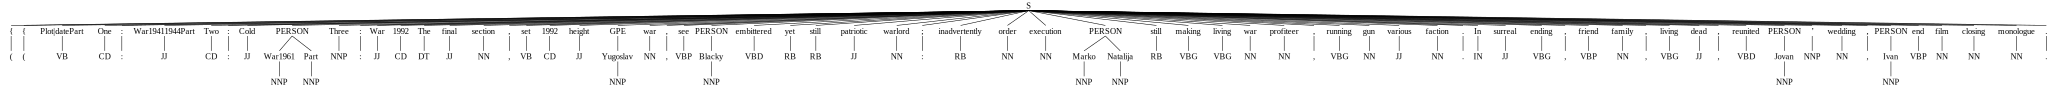

In [20]:
# Displaying one tag for verification 
full_NER_TAGS[4][0]

In [21]:
# Extracting entities 
full_entities = [[], [], [], [], [], [], []]
for i, tags in enumerate(full_NER_TAGS): 
    entities = []
    for tree in tags:
        entities.append(extracting_entities(tree))
    full_entities[i] = entities 

In [22]:
# Creating a new column in each movies dataset containing the entities
wwii_movies_side1_before['Entities'] = full_entities[0]
wwii_movies_side1_after['Entities'] = full_entities[1]
wwii_movies_side2['Entities'] = full_entities[2]
cold_war_movies_side1_before['Entities'] = full_entities[3]
cold_war_movies_side1_after['Entities'] = full_entities[4]
cold_war_movies_side2_before['Entities'] = full_entities[5]
cold_war_movies_side2_after['Entities'] = full_entities[6]



# Verification
cold_war_movies_side1_after.head()

,Movie_ID,IMDb_Index,Title,Original_Title,Release_Date,Year,Genres,Genres_IMDb,Rating,Votes,Revenue,Length,Languages,Countries,summary,event,tokenized_summaries,Entities
93,189776,tt0114787,Underground,Underground,1995-04-01,1995,"['World cinema', 'Drama', 'Comedy', 'War film'...","['Comedy,Drama,Fantasy']",8.0,61979,171082.0,170.0,"['French Language', 'SerboCroatian', 'German L...","['Serbia and Montenegro', 'Bulgaria', 'France'...",{{Plot|datePart One: War19411944Part Two: Cold...,Cold War,"[{, {, Plot|datePart, One, :, War19411944Part,...",[]
152,11347793,tt0808417,Persepolis,Persepolis,2007-06-27,2007,"['Biography', 'World cinema', 'Film adaptation...","['Animation,Biography,Drama']",8.0,101439,22752488.0,95.0,"['French Language', 'Persian Language', 'Germa...","['France', 'United States of America']",{{Copy edit-section}} The film begins at Paris...,Cold War,"[{, {, Copy, edit-section, }, }, The, film, be...","[Airport Marjane, SAVAK, Communists, Communist..."
153,1129041,tt0146309,Thirteen Days,Thirteen Days,2000-12-16,2000,"['Thriller', 'Historical fiction', 'History', ...","['Drama,History,Thriller']",7.3,63736,66579890.0,145.0,"['Russian Language', 'Romanian Language', 'Eng...",['United States of America'],"In October 1962, U-2 surveillance photos revea...",Cold War,"[In, October, 1962, ,, U-2, surveillance, phot...","[Joint Chiefs, Soviets, Guns, ABC News, DEFCON..."
159,1317604,tt0112740,Crimson Tide,Crimson Tide,1995-05-12,1995,"['Thriller', 'Action Thrillers', 'ActionAdvent...","['Action,Drama,Thriller']",7.3,126100,157387195.0,123.0,['English Language'],['United States of America'],"In post-Soviet Russia, military units loyal to...",Cold War,"[In, post-Soviet, Russia, ,, military, units, ...","[USS Alabama, Lieutenant, Alabama]"
263,5676452,tt0457090,The Marksman,The Marksman,2005-09-06,2005,"['ActionAdventure', 'Thriller', 'Action', 'Adv...","['Action,Adventure,Thriller']",4.1,4713,NaN,95.0,['English Language'],['United States of America'],Snipes plays a marksman who is sent as a spec...,Cold War,"[Snipes, plays, a, marksman, who, is, sent, as...",[]


In [24]:
import seaborn as sns
# Initializing variables necessary for iteration over all of the conflicts
wars_iterator = [wwii_movies_side1_before, wwii_movies_side1_after, wwii_movies_side2, cold_war_movies_side1_before, cold_war_movies_side1_after, cold_war_movies_side2_before, cold_war_movies_side2_after]
war_names = ['World War II Allied Side Before','World War II Allied Side After', "World War II Axis Side", 'Cold War Western Side Before', 'Cold War Western Side After', 'Cold War Sovietic Side Before', 'Cold War Sovietic Side After']# "Cold War", "Korean war", "Vietnan war"]
side_iterator = [wwii_bell_side1, wwii_bell_side1, wwii_bell_side2, cold_bell_side1, cold_bell_side1, cold_bell_side2, cold_bell_side2]
# Initializing stop words and Lemmatizer for data processing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

#### Entity-level sentiment analysis

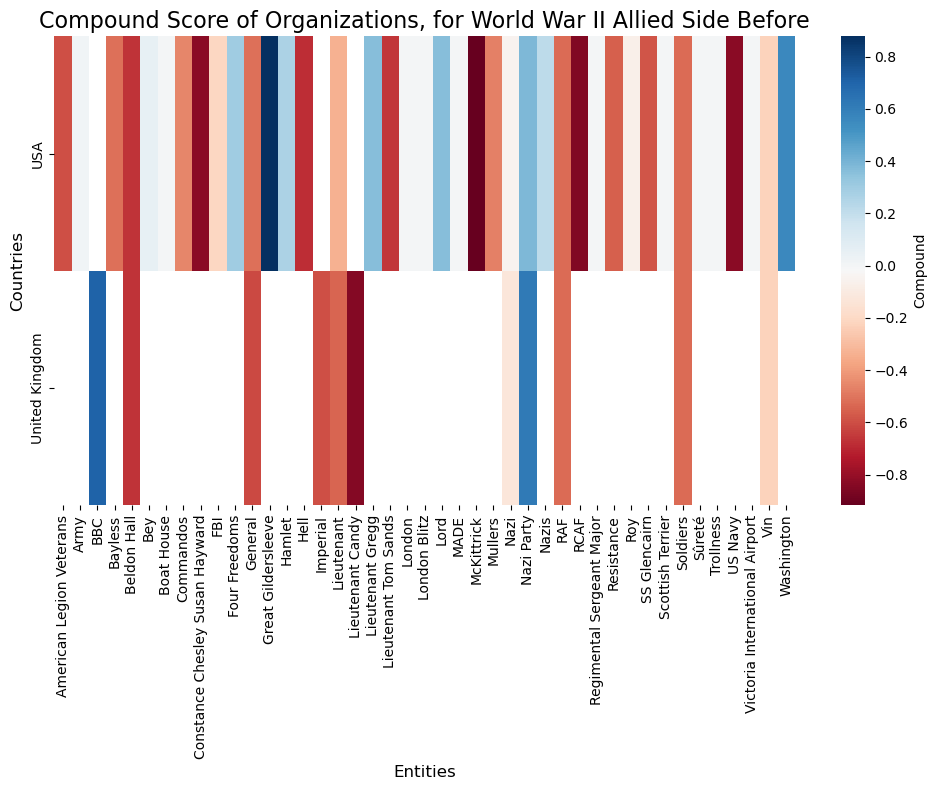

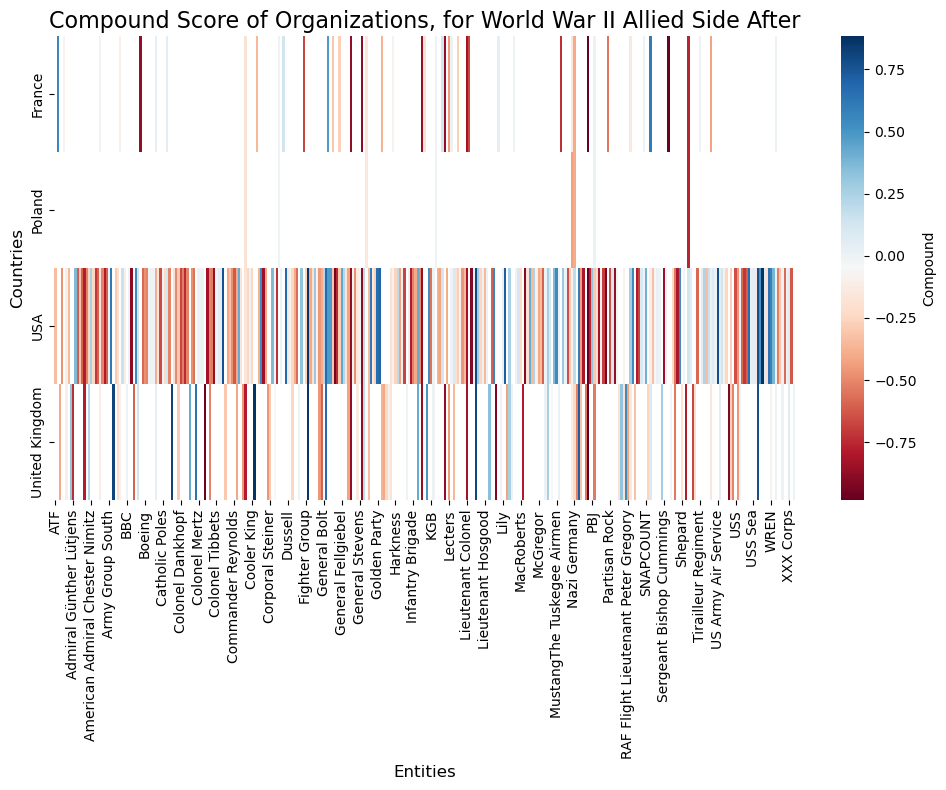

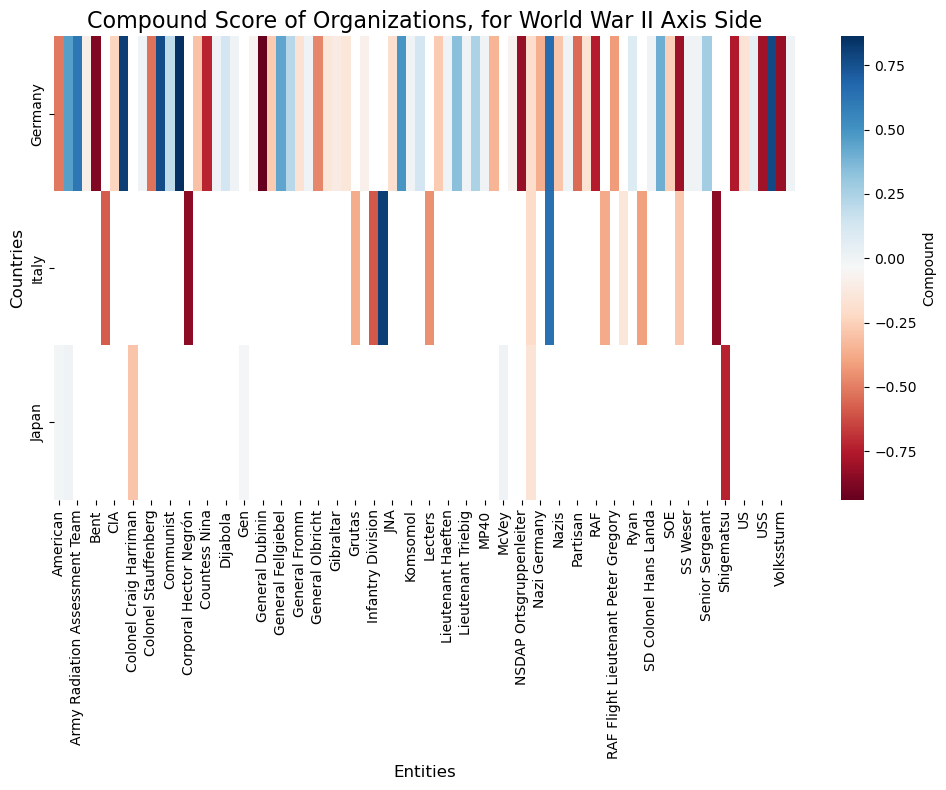

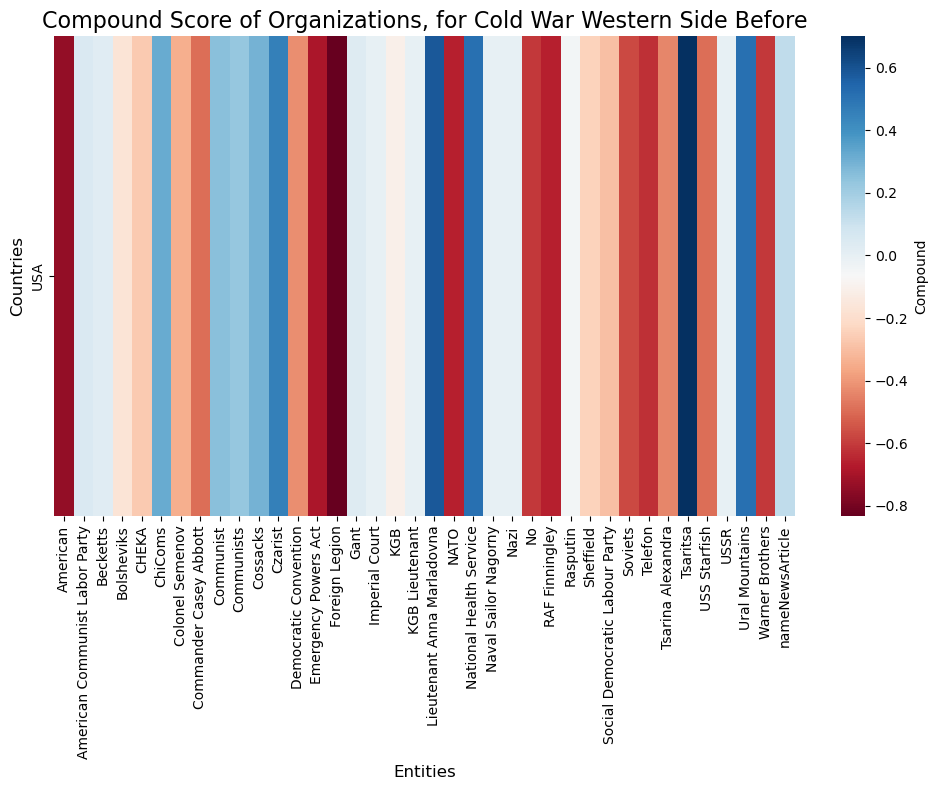

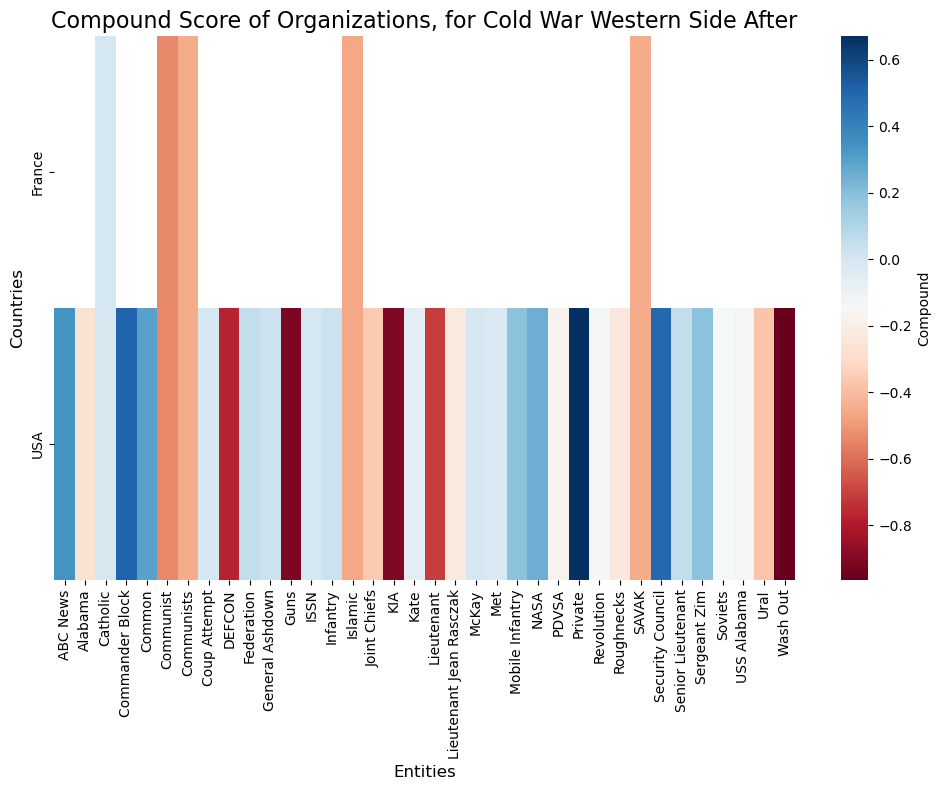

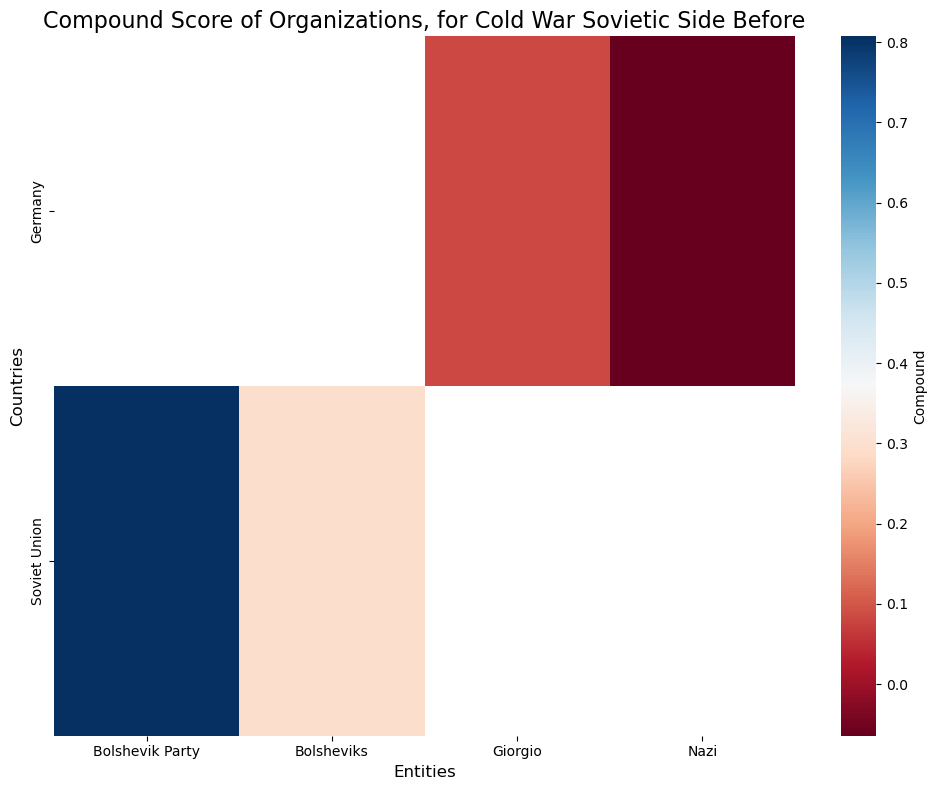

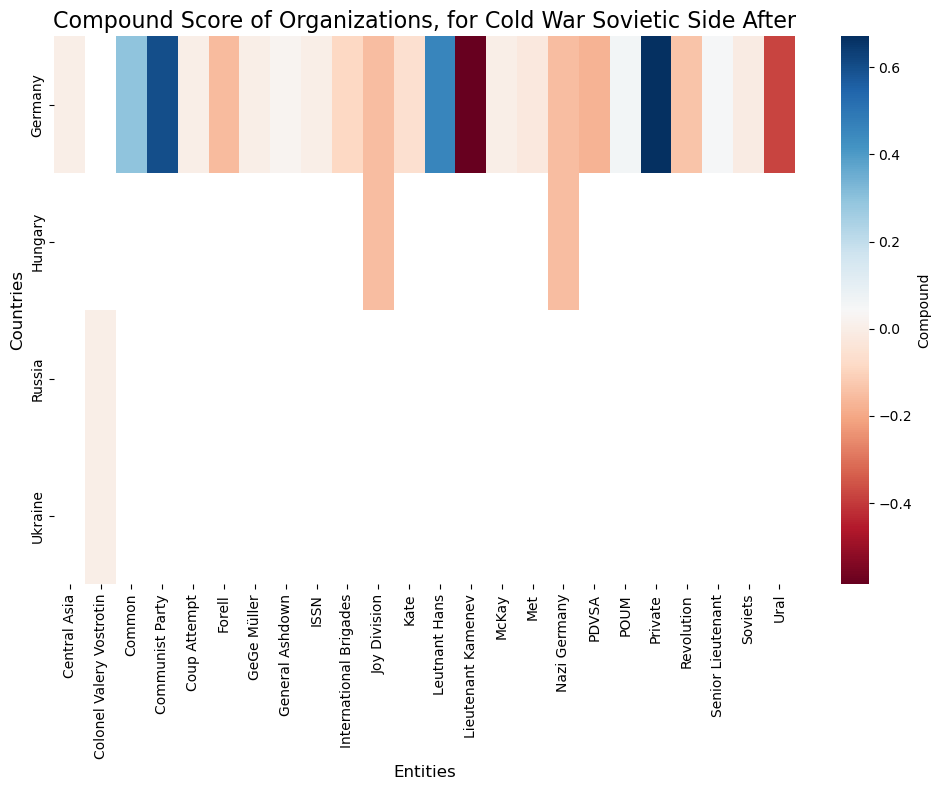

In [37]:
# Perform entity-level sentiment analysis on every conflict's subset of movies
for i, test_sample in enumerate(wars_iterator):
    # Create a new dataframe for analysis
    summaries = test_sample[['summary', 'Entities', 'Countries']]

    # Perform the entity-level analysis on each row of the dataset and appending it in the results table
    results = []
    for _, row in summaries.iterrows():
        sentiments = entity_sentiment_analysis(row["summary"], row["Entities"], row['Countries'])
        results.extend(sentiments)

    # Convert results to a DataFrame
    entity_sentiments_df = pd.DataFrame(results)

    sentiment = []
    for j in range(len(entity_sentiments_df)):
        if entity_sentiments_df.iloc[j, 2] >= 0.05:
            sentiment.append('Protagonist')
        elif entity_sentiments_df.iloc[j, 2] <= -0.05:
            sentiment.append('Antagonist')
        else:
            sentiment.append('Protagonist')

    # Create a new column for the role of the entity (Protagonist or Antagonist) and drop the duplicates 
    entity_sentiments_df['Role'] = sentiment
    #entity_sentiments_df.drop_duplicates(inplace=True)
    entity_sentiments_df['Country'] = entity_sentiments_df['Country'].apply(literal_eval)

    # Explode the dataframe on the country column in order to analyse country-wise
    entity_sentiments_df_exploded = entity_sentiments_df.explode("Country").reset_index(drop=True)

    # Remove irrelevant countries that might have appeared after exploding
    entity_sentiments_df_exploded = entity_sentiments_df_exploded[entity_sentiments_df_exploded['Country'].isin(side_iterator[i])]

    # Replacing United States of America by USA for better readability
    entity_sentiments_df_exploded.Country = entity_sentiments_df_exploded.Country.str.replace('United States of America', 'USA')

    # Aggregate by contry and sentiment range 
    aggregated_data = entity_sentiments_df_exploded.groupby(["Entity", "Country"]).agg({
    "Compound": "mean"}).reset_index()
    # Pivot aggregated data
    heatmap_data = aggregated_data.pivot(index="Country", columns="Entity", values="Compound")

    # Create a heatmap with Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=False, fmt=".2f", cmap="RdBu", xticklabels='auto', yticklabels='auto', cbar_kws={"label": "Compound"})

    # Add title and axis labels
    plt.title(f"Compound Score of Organizations, for {war_names[i]}", fontsize=16)
    plt.xlabel("Entities", fontsize=12)
    plt.ylabel("Countries", fontsize=12)

    # Save or show the heatmap
    plt.tight_layout()
    plt.show()

In [40]:
# Perform entity-level sentiment analysis on every conflict's subset of movies
for i, test_sample in enumerate(wars_iterator):
    # Create a new dataframe for analysis
    summaries = test_sample[['summary', 'Entities', 'Countries']]

    # Perform the entity-level analysis on each row of the dataset and appending it in the results table
    results = []
    for _, row in summaries.iterrows():
        sentiments = entity_sentiment_analysis(row["summary"], row["Entities"], row['Countries'])
        results.extend(sentiments)

    # Convert results to a DataFrame
    entity_sentiments_df = pd.DataFrame(results)

    sentiment = []
    for j in range(len(entity_sentiments_df)):
        if entity_sentiments_df.iloc[j, 2] >= 0.05:
            sentiment.append('Protagonist')
        elif entity_sentiments_df.iloc[j, 2] <= -0.05:
            sentiment.append('Antagonist')
        else:
            sentiment.append('Protagonist')

    # Create a new column for the role of the entity (Protagonist or Antagonist) and drop the duplicates 
    entity_sentiments_df['Role'] = sentiment
    #entity_sentiments_df.drop_duplicates(inplace=True)
    entity_sentiments_df['Country'] = entity_sentiments_df['Country'].apply(literal_eval)

    # Explode the dataframe on the country column in order to analyse country-wise
    entity_sentiments_df_exploded = entity_sentiments_df.explode("Country").reset_index(drop=True)

    # Remove irrelevant countries that might have appeared after exploding
    entity_sentiments_df_exploded = entity_sentiments_df_exploded[entity_sentiments_df_exploded['Country'].isin(side_iterator[i])]

    # Aggregate by contry and sentiment range 
    aggregated_data = entity_sentiments_df_exploded.groupby(["Entity", "Country"]).agg({
    "Compound": "mean"}).reset_index()
    # Pivot aggregated data
    heatmap_data = aggregated_data.pivot(index="Country", columns="Entity", values="Compound")


    # Create multiple frames for better visibility
    frames = []
    if war_names[i] == 'World War II Allied Side After':
        sixth= int(len(entity_sentiments_df_exploded)/6)
        # Create the initial heatmap (first frame)
        first_slide_data = entity_sentiments_df_exploded.iloc[:sixth]
        frames.append(go.Frame(
                data=[go.Heatmap(
                    z=first_slide_data["Compound"],
                    x=first_slide_data["Entity"],
                    y=first_slide_data["Country"],
                    colorscale="RdBu"
                )],
                name = '1'
            ))
        second_slide_data = entity_sentiments_df_exploded.iloc[sixth:2*sixth]
        frames.append(go.Frame(
                data=[go.Heatmap(
                    z=second_slide_data["Compound"],
                    x=second_slide_data["Entity"],
                    y=second_slide_data["Country"],
                    colorscale="RdBu"
                )],
                name = '2'
            ))
        third_slide_data = entity_sentiments_df_exploded.iloc[2*sixth:3*sixth]
        frames.append(go.Frame(
                data=[go.Heatmap(
                    z=third_slide_data["Compound"],
                    x=third_slide_data["Entity"],
                    y=third_slide_data["Country"],
                    colorscale="RdBu"
                )],
                name = '3'
            ))
        fourth_slide_data = entity_sentiments_df_exploded.iloc[3*sixth:4*sixth]
        frames.append(go.Frame(
                data=[go.Heatmap(
                    z=fourth_slide_data["Compound"],
                    x=fourth_slide_data["Entity"],
                    y=fourth_slide_data["Country"],
                    colorscale="RdBu"
                )],
                name = '4'
            ))
        
        fifth_slide_data = entity_sentiments_df_exploded.iloc[4*sixth:5*sixth]
        frames.append(go.Frame(
                data=[go.Heatmap(
                    z=fifth_slide_data["Compound"],
                    x=fifth_slide_data["Entity"],
                    y=fifth_slide_data["Country"],
                    colorscale="RdBu"
                )],
                name = '5'
            ))
        sixth_slide_data = entity_sentiments_df_exploded.iloc[5*sixth:]
        frames.append(go.Frame(
                data=[go.Heatmap(
                    z=sixth_slide_data["Compound"],
                    x=sixth_slide_data["Entity"],
                    y=sixth_slide_data["Country"],
                    colorscale="RdBu"
                )],
                name = '6'
            ))
        '''
        seventh_slide_data = entity_sentiments_df_exploded.iloc[6*sixth:7*sixth]
        frames.append(go.Frame(
                data=[go.Heatmap(
                    z=seventh_slide_data["Compound"],
                    x=seventh_slide_data["Entity"],
                    y=seventh_slide_data["Country"],
                    colorscale="RdBu"
                )],
                name = '7'
            ))
        eigth_slide_data = entity_sentiments_df_exploded.iloc[7*sixth:8*sixth]
        frames.append(go.Frame(
                data=[go.Heatmap(
                    z=eigth_slide_data["Compound"],
                    x=eigth_slide_data["Entity"],
                    y=eigth_slide_data["Country"],
                    colorscale="RdBu"
                )],
                name = '8'
            ))
        ninth_slide_data = entity_sentiments_df_exploded.iloc[8*sixth:]
        frames.append(go.Frame(
                data=[go.Heatmap(
                    z=ninth_slide_data["Compound"],
                    x=ninth_slide_data["Entity"],
                    y=ninth_slide_data["Country"],
                    colorscale="RdBu"
                )],
                name = '9'
            ))
            '''
    elif (war_names[i] != 'Cold War Sovietic Side Before'): 
        third = int(len(entity_sentiments_df_exploded)/3)
        first_slide_data = entity_sentiments_df_exploded.iloc[:third]
        frames.append(go.Frame(
                data=[go.Heatmap(
                    z=first_slide_data["Compound"],
                    x=first_slide_data["Entity"],
                    y=first_slide_data["Country"],
                    colorscale="RdBu"
                )],
                name = '1'
            ))
        second_slide_data = entity_sentiments_df_exploded.iloc[third:2*third]
        frames.append(go.Frame(
                data=[go.Heatmap(
                    z=second_slide_data["Compound"],
                    x=second_slide_data["Entity"],
                    y=second_slide_data["Country"],
                    colorscale="RdBu"
                )],
                name = '2'
            ))
        third_slide_data = entity_sentiments_df_exploded.iloc[2*third:]
        frames.append(go.Frame(
                data=[go.Heatmap(
                    z=third_slide_data["Compound"],
                    x=third_slide_data["Entity"],
                    y=third_slide_data["Country"],
                    colorscale="RdBu"
                )],
                name = '3'
            ))
    else:
        first_slide_data = entity_sentiments_df_exploded
        frames.append(go.Frame(
                data=[go.Heatmap(
                    z=first_slide_data["Compound"],
                    x=first_slide_data["Entity"],
                    y=first_slide_data["Country"],
                    colorscale="RdBu"
                )],
                name = '1'
            ))
        
    heatmap = go.Heatmap(
        z=[first_slide_data["Compound"]],
        x=first_slide_data["Entity"],
        y=first_slide_data["Country"],
        colorscale="RdBu",
        colorbar=dict(title="Sentiment Score")
    )

    # Create the heatmap
    fig = go.Figure(
        data=[heatmap] ,     # Color gradient
        frames = frames  # Colorbar title
)

    # Customize layout
    fig.update_layout(
        title=f"Compound Score of Organizations, for {war_names[i]}",
        xaxis=dict(title="Entities"),
        yaxis=dict(title="Country", automargin=True),
        width=800,  # Adjust width
        height=800,  # Adjust height
        sliders=[{
        "pad": {"t": 50, "b": 20},
        "y" : -0.3,
        "steps": [
            {"args": [[frame.name]],
            "label": frame.name,
            "method": "animate"}
            for frame in frames
        ],
        "transition": {"duration": 500},
        }],
    )
    fig.write_html(f"heatmap_{i}.html")
    fig.show()